Hunter Bennett | Glass Lab | Kupffer Strains Project | February 24 2021  

This notebook is for making fancier figure level plots describing differential gene expression for the strains NASH paper. It generates the following plots:
1. Differential scatter plot similar to those make in Link et al. 2018 showing differential peaks at fc > 2 and fc > 4.

In [27]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffgene, pull_comparisons_get_diff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [29]:
dataDirectory = '/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA/'
workingDirectory = '/home/h1bennet/strains_rna/results/A10_Manuscript_Figures_AllLiverCells/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Make folder for "fancy figures" for manuscript

In [30]:
if not os.path.isdir('./fancy_figures/'):
    os.mkdir('./fancy_figures/')

In [31]:
strains = ['aj', 'balb', 'c57']
log2fc = 1
padj = 0.05
diffpath = '/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/'

In [32]:
glob.glob(dataDirectory+'/differential/*kupffer*kupffer*homer*')

['/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA//differential/balbc_kupffer_control_young.vs.aj_kupffer_control_young.scatter.homer.txt',
 '/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA//differential/aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt',
 '/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA//differential/balbc_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt',
 '/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA//differential/c57_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.homer.txt',
 '/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA//differential/c57_kupffer_control_young.vs.aj_kupffer_control_young.scatter.homer.txt',
 '/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA//differential/aj_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.homer.txt']

### Import differential peaks

In [33]:
diff, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
    dataDirectory+'./differential/aj_hepatocyte_control_young.vs.balbc_hepatocyte_control_young.scatter.homer.txt',
    dataDirectory+'./expression/HOMER.rawTPM.txt')

ge all transcripts (24940, 43)
Diff Gene selected transcripts (5501, 14)
ge selected transcripts (5501, 43)


### Read in the amit list of KC transcripts

In [34]:
with open('/gpfs/data01/glasslab/home/h1bennet/data/Amit_KC_genelist.txt', 'r') as f:
    kc_list = [i.strip().replace('\"','') for i in f.readlines()]

# Set parameters that don't change throughout plotting

In [35]:
comps = ['aj_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.homer.txt',
         '/aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt',
         '/balbc_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt']

ids = [['AJ.*Kup', 'BALB.*Kup'],
       ['AJ.*Kup', 'C57.*Kup'],
       ['BALB.*Kup', 'C57.*Kup']]

labels = [['AJ', 'BALB/cJ'],
          ['AJ', 'C57BL/6J'],
          ['BALB/cJ', 'C57BL/6J']]

colors = [['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26']]

# set plotting thresholds
pthresh = 0.05
fontsize=8
labelsize=6
lfcthresh = (np.log2(2),np.log2(4))
dotsize = 0.5
ax_max = 16
n_yticks = 5
ytickstep = 3
color = '#636363'
filename='kupffer_spec_gene_conservation.pdf'

In [36]:
dataDirectory

'/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA/'

aj_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (7612, 14)
ge selected transcripts (7612, 43)
7612 genes
9/92 KC genes up
2/99 KC genes down
/aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (7652, 14)
ge selected transcripts (7652, 43)
7652 genes
10/125 KC genes up
9/159 KC genes down
/balbc_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (7659, 14)
ge selected transcripts (7659, 43)
7659 genes
8/180 KC genes up
11/179 KC genes down


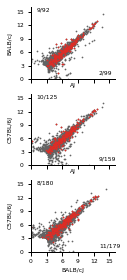

In [37]:
filename='kupffer_spec_gene_conservation_vert.pdf'
fig, axs = plt.subplots(3,1,
                        figsize=(1.5,4.5),
                        sharex=True,
                        sharey=True)
plt.subplots_adjust(wspace=0.2,
                    hspace=0.2)

# set count for labeling axes
count=0

for comp, grep, labs, color, ax in zip(comps, ids, labels, colors, axs.reshape(-1)):
    print(comp)
    de, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        dataDirectory+'./differential/'+comp,
        dataDirectory+'./expression/HOMER.rawTPM.txt',
        gene_name_index=True)
    
    # extract columns
    g0 = tpm_mat.columns.str.contains(grep[0])
    g1 = tpm_mat.columns.str.contains(grep[1])
    col = g0 | g1
    
    de['logtpm'] = np.log2(tpm_mat.loc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.padj + 10**(-50))
    de['g0_mean'] = np.log2(tpm_mat.loc[:, g0].mean(1)+1)
    de['g1_mean'] = np.log2(tpm_mat.loc[:, g1].mean(1)+1)
       
    # plot group by group scatter:
    de_all = de
    de_kc_spec = de.reindex(kc_list).dropna()
    de_sig_fc1 = de.reindex(de.index[(de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])])
    
    # genes up in group 1
    de_sig_fc1_up = de_sig_fc1.index[de_sig_fc1.log2FoldChange >= lfcthresh[0]].to_list()
    de_sig_fc1_dn = de_sig_fc1.index[de_sig_fc1.log2FoldChange <= -lfcthresh[0]].to_list()
    
    # find overlap
    kc_up = set(de_sig_fc1_up).intersection(kc_list)
    kc_dn = set(de_sig_fc1_dn).intersection(kc_list)
        
    # check number of peaks in each group
    print(de_all.shape[0], 'genes')
    print('%i/%i KC genes up' % (len(kc_up), len(de_sig_fc1_up)))
    print('%i/%i KC genes down' % (len(kc_dn), len(de_sig_fc1_dn)))
    
    for df, c in zip([de_all, de_kc_spec],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            rasterized=True)
        
    ax.text(1, 15, '%i/%i' % (len(kc_up), len(de_sig_fc1_up)))
    ax.text(13, 1, '%i/%i' % (len(kc_dn), len(de_sig_fc1_dn)))
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # set labels
    ax.set_xlabel(labs[0])
    ax.set_ylabel(labs[1])
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
plt.savefig('./fancy_figures/'+filename, bbox_inches='tight')

aj_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (7612, 14)
ge selected transcripts (7612, 43)
7612 genes
9/92 KC genes up
2/99 KC genes down
/aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (7652, 14)
ge selected transcripts (7652, 43)
7652 genes
10/125 KC genes up
9/159 KC genes down
/balbc_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (7659, 14)
ge selected transcripts (7659, 43)
7659 genes
8/180 KC genes up
11/179 KC genes down


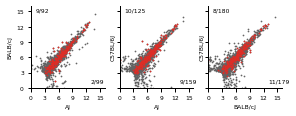

In [15]:
filename='kupffer_spec_gene_conservation.pdf'
fig, axs = plt.subplots(1,3,
                        figsize=(4.5,1.5),
                        sharex=True,
                        sharey=True)
plt.subplots_adjust(wspace=0.2,
                    hspace=0.2)

# set count for labeling axes
count=0
strain_varying_kc_spec = []


for comp, grep, labs, color, ax in zip(comps, ids, labels, colors, axs.reshape(-1)):
    print(comp)
    de, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        dataDirectory+'./differential/'+comp,
        dataDirectory+'./expression/HOMER.rawTPM.txt',
        gene_name_index=True)
    
    # extract columns
    g0 = tpm_mat.columns.str.contains(grep[0])
    g1 = tpm_mat.columns.str.contains(grep[1])
    col = g0 | g1
    
    de['logtpm'] = np.log2(tpm_mat.loc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.padj + 10**(-50))
    de['g0_mean'] = np.log2(tpm_mat.loc[:, g0].mean(1)+1)
    de['g1_mean'] = np.log2(tpm_mat.loc[:, g1].mean(1)+1)
       
    # plot group by group scatter:
    de_all = de
    de_kc_spec = de.reindex(kc_list).dropna()
    de_sig_fc1 = de.reindex(de.index[(de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])])
    
    # genes up in group 1
    de_sig_fc1_up = de_sig_fc1.index[de_sig_fc1.log2FoldChange >= lfcthresh[0]].to_list()
    de_sig_fc1_dn = de_sig_fc1.index[de_sig_fc1.log2FoldChange <= -lfcthresh[0]].to_list()
    
    # find overlap
    kc_up = set(de_sig_fc1_up).intersection(kc_list)
    kc_dn = set(de_sig_fc1_dn).intersection(kc_list)
    # store overlap
    strain_varying_kc_spec.extend(set(kc_up))
    strain_varying_kc_spec.extend(set(kc_dn))
        
    # check number of peaks in each group
    print(de_all.shape[0], 'genes')
    print('%i/%i KC genes up' % (len(kc_up), len(de_sig_fc1_up)))
    print('%i/%i KC genes down' % (len(kc_dn), len(de_sig_fc1_dn)))
    
    for df, c in zip([de_all, de_kc_spec],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            rasterized=True)
        
    ax.text(1, 15, '%i/%i' % (len(kc_up), len(de_sig_fc1_up)))
    ax.text(13, 1, '%i/%i' % (len(kc_dn), len(de_sig_fc1_dn)))
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # set labels
    ax.set_xlabel(labs[0])
    ax.set_ylabel(labs[1])
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
plt.savefig('./fancy_figures/'+filename, bbox_inches='tight')

In [16]:
len(set(strain_varying_kc_spec))

33

In [17]:
len(kc_list)

303